In [ ]:
import pandas as pd
import numpy as np
import re
import string
from bs4 import BeautifulSoup
!pip install contractions
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!pip install gensim
!pip install --upgrade --force-reinstall numpy gensim

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import matplotlib.pyplot as plt


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp

In [ ]:

# NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
df = pd.read_csv("spam.csv", encoding="latin-1")[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:

# Preprocessing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words

df['tokens'] = df['text'].apply(preprocess)



In [12]:

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)


In [13]:

# Average Word2Vec vectors
def sentence_vector(tokens):
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_embed = np.array([sentence_vector(tokens) for tokens in df['tokens']])
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, test_size=0.2, random_state=42)



In [14]:
# ML Models with Grid Search
model_grid = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'model__C': [0.1, 1, 10], 'model__solver': ['lbfgs']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]}
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear']}
    }
}

def evaluate_model(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n📊 {name} Evaluation:")
    print(f"  ✅ Accuracy:  {acc:.4f}")
    print(f"  ✅ Precision: {prec:.4f}")
    print(f"  ✅ Recall:    {rec:.4f}")
    print(f"  ✅ F1-score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")




🔍 Tuning Logistic Regression...
✅ Best Params: {'model__C': 10, 'model__solver': 'lbfgs'}

📊 Logistic Regression Evaluation:
  ✅ Accuracy:  0.8897
  ✅ Precision: 0.8462
  ✅ Recall:    0.2200
  ✅ F1-score:  0.3492


<Figure size 1000x600 with 0 Axes>

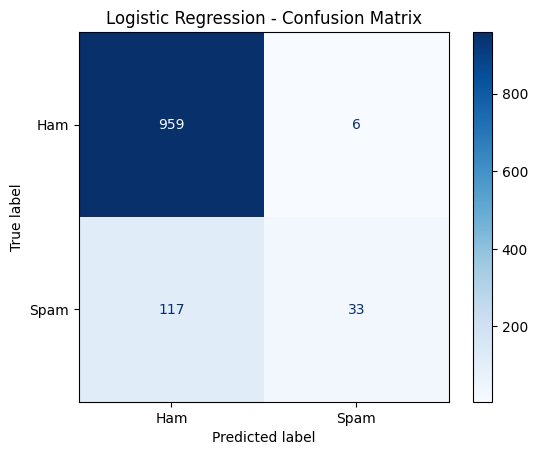


🔍 Tuning Random Forest...
✅ Best Params: {'model__max_depth': None, 'model__n_estimators': 100}

📊 Random Forest Evaluation:
  ✅ Accuracy:  0.9507
  ✅ Precision: 0.9612
  ✅ Recall:    0.6600
  ✅ F1-score:  0.7826


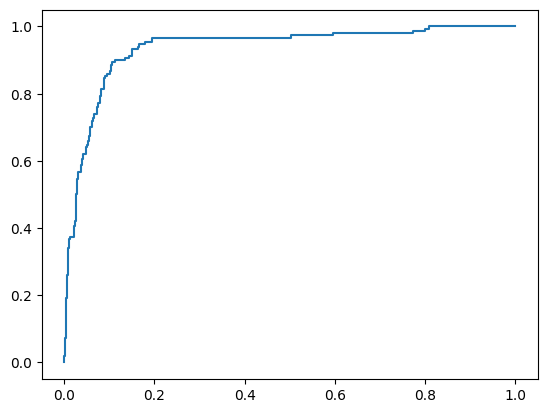

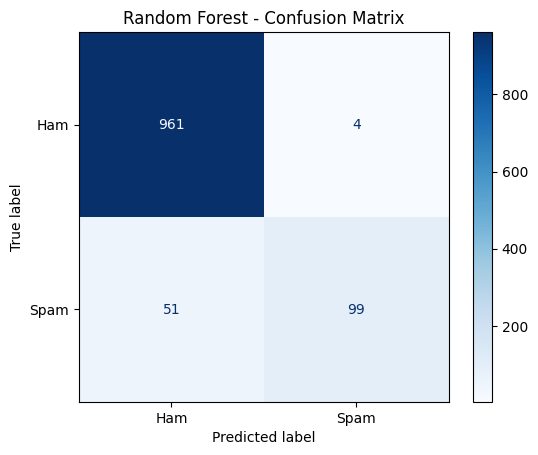


🔍 Tuning SVM...
✅ Best Params: {'model__C': 10, 'model__kernel': 'linear'}

📊 SVM Evaluation:
  ✅ Accuracy:  0.9076
  ✅ Precision: 0.8730
  ✅ Recall:    0.3667
  ✅ F1-score:  0.5164


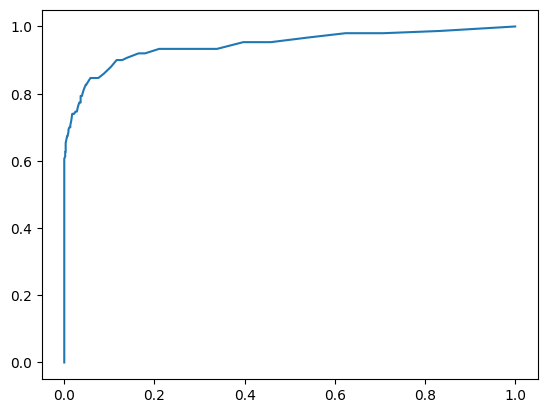

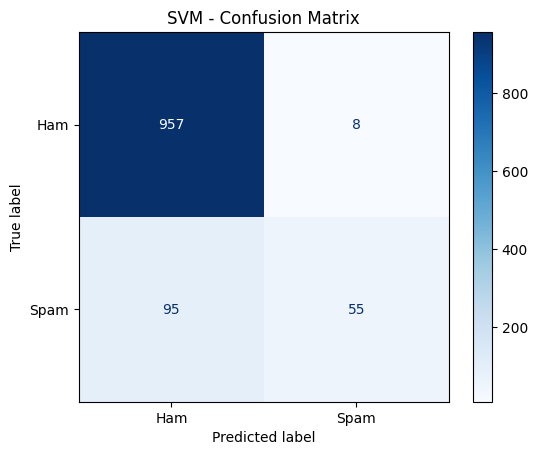

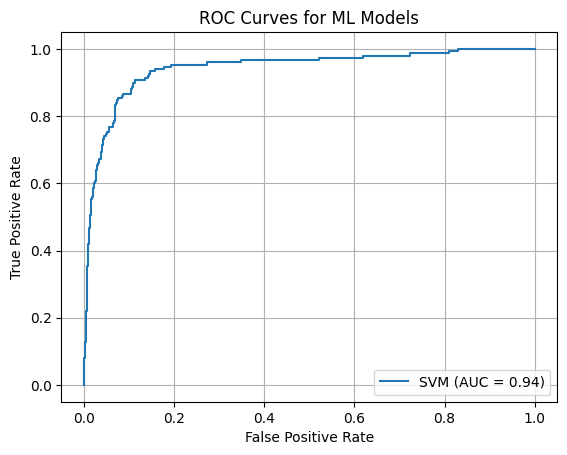

In [15]:
# Train & Evaluate ML Models
plt.figure(figsize=(10, 6))

for name, config in model_grid.items():
    print(f"\n🔍 Tuning {name}...")
    pipeline = Pipeline([('model', config['model'])])
    grid = GridSearchCV(pipeline, config['params'], cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"✅ Best Params: {grid.best_params_}")
    y_pred = grid.best_estimator_.predict(X_test)
    y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]

    evaluate_model(name, y_test, y_pred, y_proba)

plt.title("ROC Curves for ML Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [16]:

# Tokenize and pad sequences for LSTM
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'])
sequences = tokenizer.texts_to_sequences(df['tokens'])
X_seq = pad_sequences(sequences, maxlen=50)
y_seq = df['label'].values
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


In [17]:

# Build embedding matrix from Word2Vec
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, idx in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[idx] = word2vec_model.wv[word]


In [18]:

# LSTM Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                    input_length=50, trainable=False))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=32, validation_split=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       788,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 788,000 (3.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 788,000 (3.01 MB)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.8590 - loss: 0.4641 - val_accuracy: 0.8655 - val_loss: 0.3105
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8718 - loss: 0.2783 - val_accuracy: 0.8655 - val_loss: 0.3113
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8865 - loss: 0.2629 - val_accuracy: 0.8789 - val_loss: 0.2949
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8808 - loss: 0.2847 - val_accuracy: 0.8744 - val_loss: 0.2981
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8914 - loss: 0.2658 - val_accuracy: 0.8946 - val_loss: 0.2796


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

📊 LSTM Evaluation:
  ✅ Accuracy:  0.9049
  ✅ Precision: 0.7000
  ✅ Recall:    0.5133
  ✅ F1-score:  0.5923


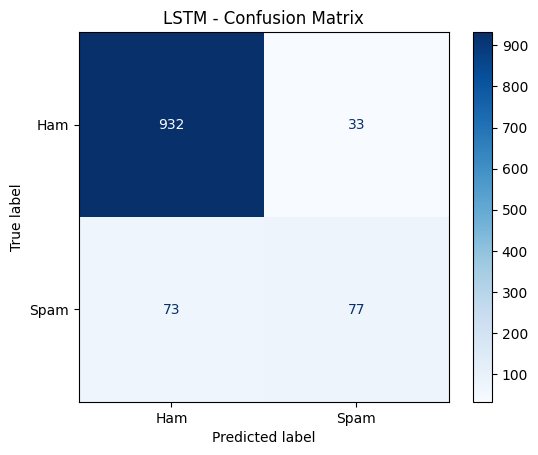

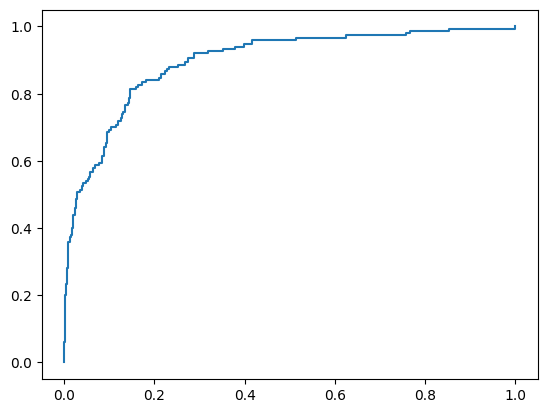

In [19]:

# Evaluate LSTM
y_pred_lstm = (model.predict(X_test_seq) > 0.5).astype("int32").flatten()
y_proba_lstm = model.predict(X_test_seq).flatten()
evaluate_model("LSTM", y_test_seq, y_pred_lstm, y_proba_lstm)